In [1]:
import numpy as np
import xarray as xr
import sys
import yaml
from scipy import signal
from dateutil.parser import parse
from matplotlib import pyplot as plt
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import aggregate_mpas_2Dvariables as aggr
import postprocesstools as pptools
import visualizationtools as viz

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

In [123]:
# Path, meshes and timeranges
resultspath = '/pscratch/sd/b/bmoorema/results/aggregated/lonlat/'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]

# Loop though meshes and timeranges
ds = {mesh: {} for mesh in meshes}
for mesh in meshes:
    for timerange in timeranges:
        
        # Construct strings and load 2D fields via xarray
        tstr = '_'.join(date.strftime('%Y%m%d') for date in timerange)
        fn = resultspath + '20210421_sim7_CORE_' + mesh + '.mpas2Dtimeavg_wmt_' + tstr + '.nc'
        tstr = '-'.join(str(date.year) for date in timerange)
        ds[mesh][tstr] = xr.open_dataset(fn)

***

### Figure 1

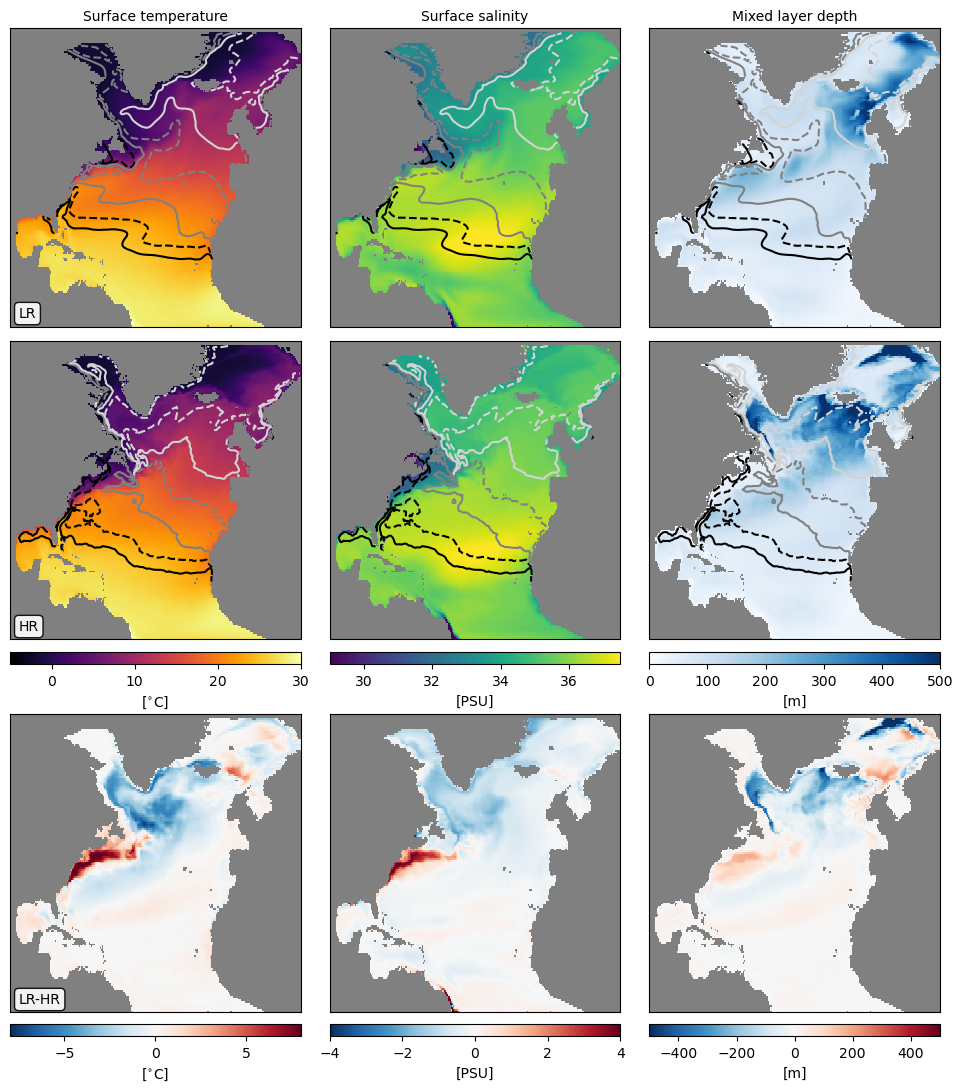

In [124]:
# Plotting info
varnames = ['temperature', 'salinity', 'dThreshMLD']
cmaps = ['inferno', 'viridis', 'Blues']
clims = [[-5, 30, 8], [29, 37.5, 4], [0, 500, 500]]
titles = ['Surface temperature', 'Surface salinity', 'Mixed layer depth']
units = ['[$^{\circ}$C]', '[PSU]', '[m]']
props = {'fc': 'w', 'boxstyle': 'round', 'alpha': 0.9}

# Make figure
fig, axs = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.05})

# Loop through time ranges
for col, varname, cmap, clim, title, unit in zip(axs.T, varnames, cmaps, clims, titles, units):

    # --- Plot meshes ---------
    res = []
    for ax, mesh in zip(col, ds):

        # Slice dataset
        ds_slc = ds[mesh]['1997-2006'].sel(depths=0, months=[12, 1, 2]).mean(dim='months')

        # Plot sliced dataset
        c1, variable = viz.plot_2Dpanel(
            ax, ds_slc, varname, clim=clim[:2], cmap=cmap, plot_sigma=True,
        )
        res.append(variable)

    # --- Plot residual -------
    res = np.subtract(*res)
    pos = col[2].get_position()
    col[2].set_position([pos.x0, pos.y0-0.05, pos.width, pos.height])
    c2, _ = viz.plot_2Dpanel(col[2], res, clim=[-clim[2], clim[2]], cmap='RdBu_r')

    # Add colorbars
    cax1 = fig.add_axes([pos.x0, pos.y0+0.24, pos.width, 0.01])
    cax2 = fig.add_axes([pos.x0, pos.y0-0.07, pos.width, 0.01])
    fig.colorbar(c1, cax=cax1, label=unit, orientation='horizontal')
    fig.colorbar(c2, cax=cax2, label=unit, orientation='horizontal')
    col[0].set_title(title)
    if varname == varnames[0]:
        for ax, label in zip(col, ['LR', 'HR', 'LR-HR']):
            ax.text(0.03, 0.03, label, transform=ax.transAxes, bbox=props)

fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/biases.pdf', bbox_inches='tight')

***

### Figure 2

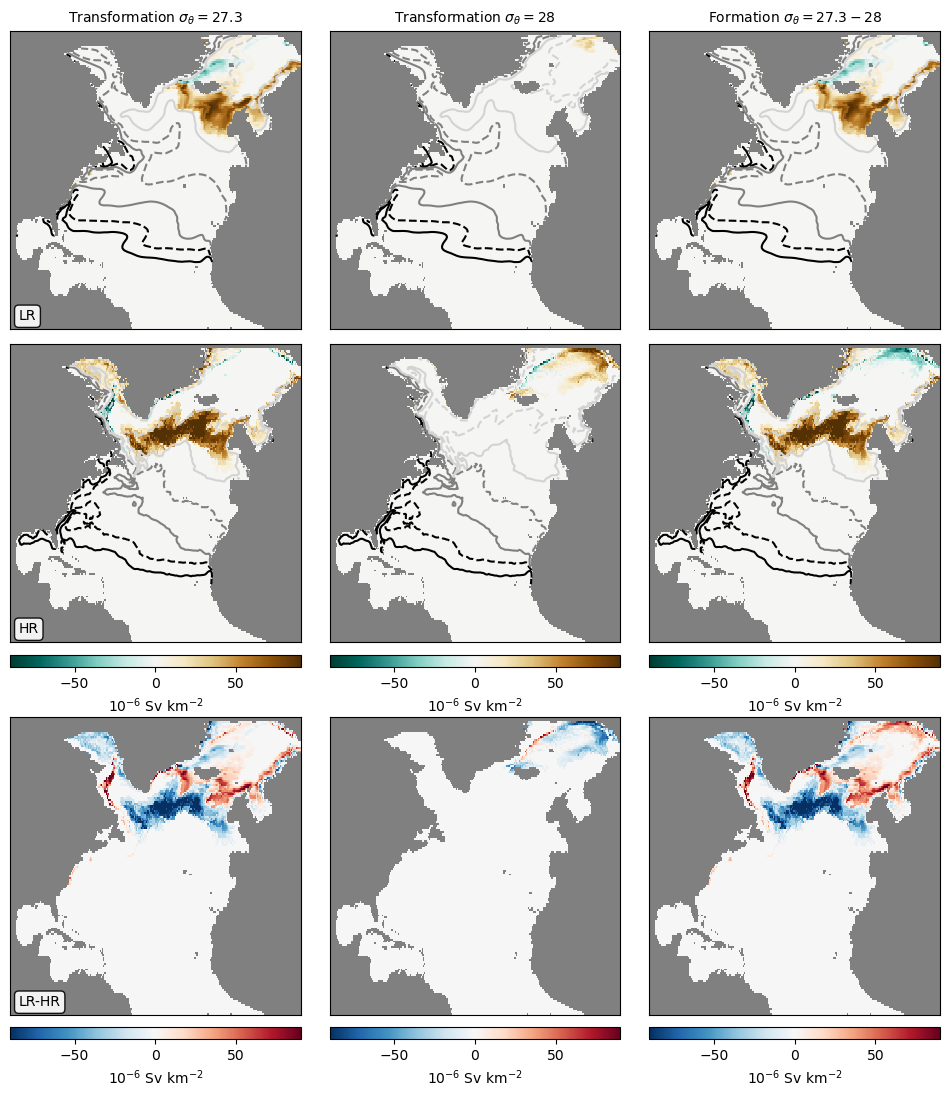

In [125]:
# Plotting info
varnames = ['totalTrans', 'totalTrans', 'totalForm']
sigmaBins = [27.3, 28, slice(27.3, 28)]
titles = [
    'Transformation $\\sigma_{\\theta}=27.3$',
    'Transformation $\\sigma_{\\theta}=28$',
    'Formation $\\sigma_{\\theta}=27.3-28$',
]
units = '10$^{-6}$ Sv km$^{-2}$'

# Make figure
fig, axs = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.05})

# Loop through time ranges
for col, varname, sigmaBin, title in zip(axs.T, varnames, sigmaBins, titles):

    # --- Plot meshes ---------
    res = []
    for ax, mesh in zip(col, ds):

        # Slice dataset
        ds_slc = ds[mesh]['1997-2006'].sel(depths=0, months=[12, 1, 2], sigmaBins=sigmaBin).mean(dim='months')
        if 'sigmaBins' in ds_slc.dims: ds_slc = ds_slc.sum(dim='sigmaBins', skipna=False)

        # Plot sliced dataset
        c1, variable = viz.plot_2Dpanel(
            ax, ds_slc, varname, clim=[-90, 90], cmap='BrBG_r', plot_sigma=True,
        )
        res.append(variable)

    # --- Plot residual -------
    res = np.subtract(*res)
    pos = col[2].get_position()
    col[2].set_position([pos.x0, pos.y0-0.05, pos.width, pos.height])
    c2, _ = viz.plot_2Dpanel(col[2], res, clim=[-90, 90], cmap='RdBu_r')
    
    # Add colorbars
    cax1 = fig.add_axes([pos.x0, pos.y0+0.24, pos.width, 0.01])
    cax2 = fig.add_axes([pos.x0, pos.y0-0.07, pos.width, 0.01])
    fig.colorbar(c1, cax=cax1, label=units, orientation='horizontal')
    fig.colorbar(c2, cax=cax2, label=units, orientation='horizontal')
    col[0].set_title(title)
    if sigmaBin == sigmaBins[0]:
        for ax, label in zip(col, ['LR', 'HR', 'LR-HR']):
            ax.text(0.03, 0.03, label, transform=ax.transAxes, bbox=props)

fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/2D_WMT.pdf', bbox_inches='tight')

***

### Figure 3

In [9]:
# Path, meshes and timeranges
resultspath = '/pscratch/sd/b/bmoorema/results/aggregated/timeseries/'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]

# Loop though meshes and timeranges
ds = {}
for mesh in meshes:
        
    # Construct strings and load 2D fields via xarray
    fn = resultspath + '20210421_sim7_CORE_' + mesh + '.mpastimeseries_wmt_19470101_20061201.nc'
    ds[mesh] = xr.open_dataset(fn)

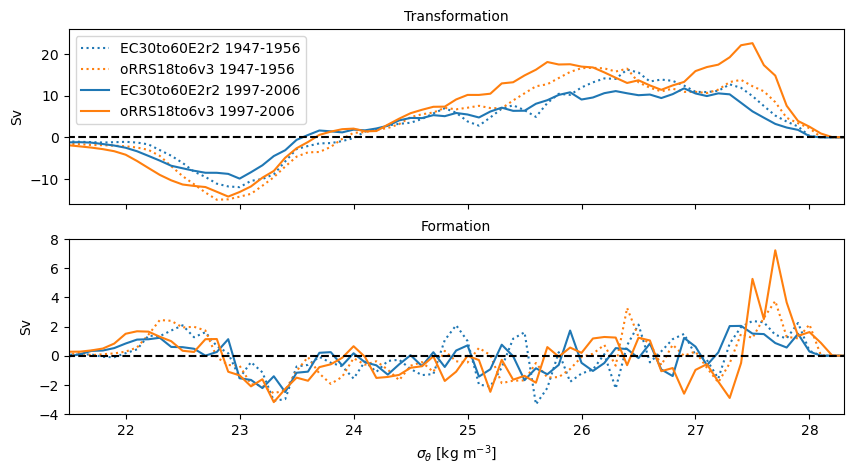

In [10]:
# Plot total WMT, all months
ylims = [(-16, 26), (-4, 8)]
fig, axs = viz.plot_wmt_sigma(ds, 'total', timeranges, ylims=ylims)
#fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/WMT_sigmaspace.pdf', bbox_inches='tight')

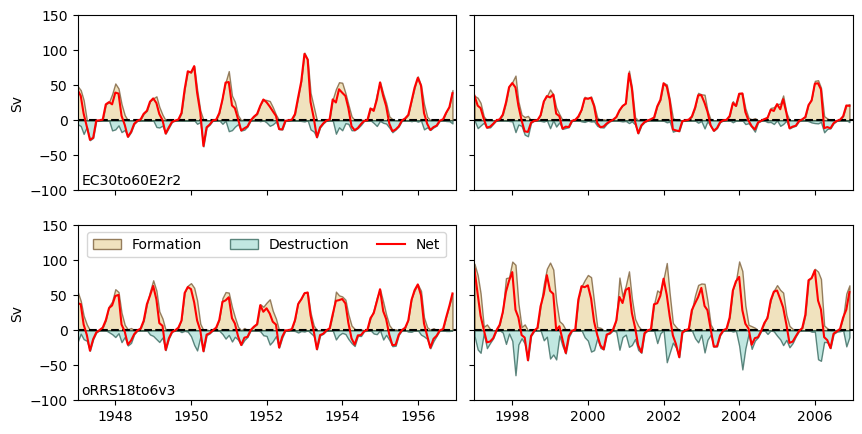

In [128]:
fig, axs = viz.plot_wmt_timeseries(ds, 'totalForm', timeranges, [27.3, 28])
fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/WMT_timeseries.pdf', bbox_inches='tight')

***

### New analysis

**Overturning circulation in the SPNA overview:**

   1. SPMW forms at lighter density classes in the SPG along OSNAP-E to become UNADW
   2. SPMW forms at heavier density classes in the GIN seas to become LNADW
   3. These water masses contribute approximately equally to the overturning transport through OSNAP-E
   4. A portion of this overturning export flows through the Lab Sea via the WGC and LC boundary currents
   5. The boundary currents mix with deep convection in the Lab Sea via eddy processes
   6. DWBC + interior overturning becomes NADW, but significant recirculation occurs in the SPG

**Thoughts:**

   1. Check the SPMW contributions in the SPNA and GIN seas and compare to transport through OSNAP-E
      - Do they balance?
      - Do they increase/decrease simultaneously or is there a lag?

In [109]:
def lowpass(x, windowsize=5):
    """Lowpass filter
    """
    
    # Lowpass filter
    window = signal.windows.blackman(windowsize)
    y = np.convolve(x, window / sum(window), mode='same')
    
    return y


def interpolate_to_edge(varCell, cellsOnEdge, subdomain, cutoff=0):
    """Interpolate cell variable to edge
    """

    # Interpolate to edge
    varEdge = []
    for pair in cellsOnEdge:
        index, = np.where(np.isin(subdomain, pair))
        values = varCell[index, :]
        values[values <= cutoff] = np.nan
        varEdge.append(values.mean(axis=0))
    varEdge = np.vstack(varEdge)
    
    return varEdge


def load_mesh_variables(paths):
    """Load mesh variables
    """

    # Load mesh variables
    with xr.open_dataset(paths['meshfile']) as ds:
        nCells = ds.nCells.values
        lonCell = np.rad2deg(ds.lonCell.values)
        latCell = np.rad2deg(ds.latCell.values)
        lonEdge = np.rad2deg(ds.lonEdge.values)
        latEdge = np.rad2deg(ds.latEdge.values)
        areaCell = ds.areaCell.values
        cellsOnEdge = ds.cellsOnEdge.values - 1
        edgesOnCell = ds.edgesOnCell.values - 1
        dvEdge = ds.dvEdge.values
        lonCell[lonCell > 180] = lonCell[lonCell > 180] - 360
        lonEdge[lonEdge > 180] = lonEdge[lonEdge > 180] - 360

    # Load mask variables
    with xr.open_dataset(paths['maskfile']) as ds:
        regionNames = ds.regionNames.values.astype(str)
        regionMasks = ds.regionCellMasks.values

    # Load transect variables
    with xr.open_dataset(paths['transectfile']) as ds:
        sectionNames = ds.transectNames.values.astype(str)
        sectionMasks = ds.transectEdgeMasks.values
        sectionMaskSigns = ds.transectEdgeMaskSigns.values

    # Subdomain
    regionlist = [list(region) for region in regions.values()]
    regionlist = regionlist[0] + regionlist[1]
    index = np.isin(regionNames, regionlist)
    subdomainCell, = np.where(regionMasks[:, index].sum(axis=1).astype(bool))                       
    subdomainEdge, = np.where((lonEdge > -44) & (lonEdge < -3) & (latEdge > 56) & (latEdge < 69))

    # Make dict
    coords = {
        'subdomainCell': subdomainCell,
        'subdomainEdge': subdomainEdge,
        'lonCell': lonCell[subdomainCell],
        'latCell': latCell[subdomainCell],
        'lonEdge': lonEdge[subdomainEdge],
        'latEdge': latEdge[subdomainEdge],
        'areaCell': areaCell[subdomainCell],
        'regionNames': regionNames,
        'regionMasks': regionMasks[subdomainCell, :],
        'sectionNames': sectionNames,
        'sectionMasks': sectionMasks[subdomainEdge, :],
        'sectionMaskSigns': sectionMaskSigns[subdomainEdge, :],
        'cellsOnEdge': cellsOnEdge[subdomainEdge, :],
        'dvEdge': dvEdge[subdomainEdge],
    }

    return coords


def load_results_variables(date, paths, coords):
    """Load results variables
    """
    
    # Load results
    f = aggr.build_MPASO_filename(date, dateranges, paths)
    with xr.open_dataset(f) as ds:

        # Get TS and state variables
        names, prefix = ['temperature', 'salinity'], 'timeMonthly_avg_activeTracers_'
        results = {name: ds[prefix + name][0, :, 0].values[coords['subdomainCell']] for name in names}
        results = aggr.calc_state_variables(results)

        # Get buoyancy fluxes
        prefix = 'timeMonthly_avg_'
        for ctgy in ['heat', 'salt']:
            label = ctgy.capitalize() + 'Flux'
            flux = sum([ds[prefix + name][0, :].values[coords['subdomainCell']] for name in fluxdefs['total' + label]])
            results['buoyancy' + label] = flux * results[ctgy + 'Factor']
        results['buoyancyTotalFlux'] = results['buoyancyHeatFlux'] + results['buoyancySaltFlux']

        # Get edge transport variables
        results['velocityNormal'] = ds.timeMonthly_avg_normalVelocity[0, coords['subdomainEdge'], :].values
        results['layerThickness'] = ds.timeMonthly_avg_layerThickness[0, coords['subdomainCell'], :].values
        results['sigmaTheta3D'] = ds.timeMonthly_avg_potentialDensity[0, coords['subdomainCell'], :].values - 1000
        results['volume'] = results['layerThickness'] * coords['areaCell'][:, None]

    return results


def calc_wmt(results, coords, regionNames):
    """Calculate water mass transformation and formation in sigma space
    """

    # Calculate region mask
    index = np.isin(coords['regionNames'], regionNames)
    regionMask = coords['regionMasks'][:, index].sum(axis=1).astype(bool)

    # Loop through sigmabins
    data = {ctgy: [] for ctgy in ['heat', 'salt', 'total']}
    for sigmabin in sigmabins:
        sigmaMask = (results['sigmaTheta'] >= sigmabin) & (results['sigmaTheta'] < sigmabin + binsize)
        mask = regionMask & sigmaMask
        for ctgy in data:
            buoyancyFluxInt2D = results[f'buoyancy{ctgy.capitalize()}Flux'][mask] * coords['areaCell'][mask]
            data[ctgy].append(buoyancyFluxInt2D.sum())

    # Concatenate, scale and differentiate
    for ctgy in data:
        transformation = np.array(data[ctgy]) / binsize * 1e-6
        formation = -np.diff(transformation)
        wmt[ctgy + 'Trans'] = transformation[:-1]
        wmt[ctgy + 'Form'] = formation

    return wmt


def calc_transport(results, coords, sectionNames):
    """Calculate transport in sigma space
    """

    # Calculate section mask
    index = np.isin(coords['sectionNames'], sectionNames)
    sectionMask, = np.where(coords['sectionMasks'][:, index].sum(axis=1).astype(bool))
    cellsOnEdge = coords['cellsOnEdge'][sectionMask, :]
    sectionMask = sectionMask[np.logical_and(*np.isin(cellsOnEdge, coords['subdomainCell']).T)]
    cellsOnEdge = coords['cellsOnEdge'][sectionMask, :]
    sectionMaskSigns = coords['sectionMaskSigns'][sectionMask, :][:, index].sum(axis=1)[:, None]
    dvEdge = coords['dvEdge'][sectionMask][:, None]

    # Extract variables along section and interpolate to edge
    velocityNormal = results['velocityNormal'][sectionMask, :]
    sigmaTheta = interpolate_to_edge(results['sigmaTheta3D'], cellsOnEdge, coords['subdomainCell'])
    layerThickness = interpolate_to_edge(results['layerThickness'], cellsOnEdge, coords['subdomainCell'])

    # Transport
    transport = velocityNormal * layerThickness * dvEdge * sectionMaskSigns

    # Bin by density
    binned = []
    for sigmabin in sigmabins:
        sigmaMask = (sigmaTheta >= sigmabin) & (sigmaTheta < sigmabin + binsize)
        binned.append(transport[sigmaMask].sum() * 1e-6)
    transport = np.array(binned)

    return transport


def calc_volume(results, coords, regionNames):
    """
    """
    
    # Calculate region mask
    index = np.isin(coords['regionNames'], regionNames)
    regionMask = coords['regionMasks'][:, index].sum(axis=1).astype(bool)
    
    # Loop through sigmabins
    volume = []
    for sigmabin in sigmabins:
        sigmaMask = (results['sigmaTheta3D'] >= sigmabin) & (results['sigmaTheta3D'] < sigmabin + binsize)
        mask = regionMask[:, None] & sigmaMask
        volume.append(results['volume'][mask].sum())
    volume = np.array(volume)
    
    return volume


def build_timeseries(paths, coords):
    """Build timeseries of WMT and transport
    """
        
    # Init wmt
    wmt = {region: {} for region in regions}
    volume_tendency = {region: [] for region in regions}
    transport = {section: [] for section in sections}
    volume_last = {}

    # Loop through months
    date_last = None
    for date in tqdm(time):

        # Load month and concatenate
        results = load_results_variables(date, paths, coords)
        
        # Loop through regions
        for region in regions:
            
            # Calc WMT
            data = calc_wmt(results, coords, regions[region])
            for name in data:
                if name not in wmt[region]:
                    wmt[region][name] = []
                wmt[region][name].append(data[name])
            
            # Calc volume tendency
            volume = calc_volume(results, coords, regions[region])
            if date_last is not None:
                dVdt = (volume - volume_last[region]) / (date - date_last).total_seconds() * 1e-6
                volume_tendency[region].append(dVdt)
            volume_last[region] = volume
        
        # Loop through sections
        for section in sections:
            data = calc_transport(results, coords, sections[section])
            transport[section].append(data)
        
        # Update previous date
        date_last = date
    
    # Concatenate wmt
    for region in regions:
        for name in wmt[region]:
            wmt[region][name] = np.vstack(wmt[region][name])
        volume_tendency[region] = np.vstack(volume_tendency[region])
    
    # Concatenate transport
    for section in sections:
        transport[section] = np.vstack(transport[section])
            
    return wmt, volume_tendency, transport


def plot_wmt(ax, varname, months, ylim):
    """Plot WMT
    """

    # Plot WMT
    palette = plt.get_cmap('tab10').colors
    for mesh, ls in zip(['LR', 'HR'], [':', '-']):
        for region, color in zip(['SPNA', 'GIN Sea'], palette):
            label = region if mesh == 'HR' else ''
            y = lowpass(wmt[mesh][varname][region][slice(*months), :].mean(axis=0))
            ax.plot(sigmabins[:-1], y, ls, color=color, label=label)
    
    # Formatting
    xlim = [27, 28.2]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(xlim, [0, 0], 'k--', zorder=0)
    ax.legend()

In [101]:
# Define parameters and load mesh and mask variables
regions = {
    'SPNA': ('Irminger Sea', 'Iceland Basin', 'Rockall Trench'),
    'GIN Sea': ('Greenland Sea', 'Norwegian Sea'),
}
sections = {
    'OSNAP East': ('OSNAP section East'),
    'Greenland-Scotland': ('Denmark Strait', 'Iceland-Faroe-Scotland'),
}

# Build sigma variables
sigmarange, binsize = [27, 28.21], 0.01
sigmabins = pptools.build_sigma_bins(sigmarange, binsize).values

# Load paths dict from yaml
with open('../yaml/variable_combinations.yaml', 'r') as f:
    fluxdefs = yaml.safe_load(f)

# Load paths dict from yaml and load mesh variables
paths, coords = {}, {}
for mesh in ['LR', 'HR']:
    with open(f'../yaml/paths_{mesh}.yaml', 'r') as f:
        paths[mesh] = yaml.safe_load(f)
    coords[mesh] = load_mesh_variables(paths[mesh])

# Build time array
time, dateranges = aggr.build_time_array(paths['LR']['results'])

In [13]:
wmt, volume_tendency, transport = {}, {}, {}
wmt['HR'], volume_tendency['HR'], transport['HR'] = build_timeseries(paths['HR'], coords['HR'])

100%|██████████| 240/240 [1:05:18<00:00, 16.33s/it]


In [102]:
wmt['LR'], volume_tendency['LR'], transport['LR'] = build_timeseries(paths['LR'], coords['LR'])

100%|██████████| 240/240 [05:22<00:00,  1.34s/it]


In [116]:
mesh = 'LR'

# Coords
coordinates = {
    'regionNames': list(regions),
    'sectionNames': list(sections),
    'time': time,
    'sigmaBins': sigmabins[:-1],
}

# Region variables
variables = {}
dims = ['regionNames', 'time', 'sigmaBins']
variables['volume_tendency'] = np.concatenate([volume_tendency[mesh][region][None, ...] for region in regions])
variables['volume_tendency'] = np.append(variables['volume_tendency'], np.zeros((2, 1, 122)), axis=1)[..., :-1]
variables['volume_tendency'] = (dims, variables['volume_tendency'])
for name in wmt[mesh]['SPNA']:
    variables[name] = (dims, np.concatenate([wmt[mesh][region][name][None, ...] for region in regions]))

# Section variables
dims = ['sectionNames', 'time', 'sigmaBins']
variables['transport'] = (dims, np.concatenate([transport[mesh][section][None, :, :-1] for section in sections]))

# Dataset
ds = xr.Dataset(variables, coordinates)
ds.to_netcdf('/pscratch/sd/b/bmoorema/results/workspace/sigmaspace_LR.nc')

In [2]:
ds = {}
ds['LR'] = xr.open_dataset('/pscratch/sd/b/bmoorema/results/workspace/sigmaspace_LR.nc')
ds['HR'] = xr.open_dataset('/pscratch/sd/b/bmoorema/results/workspace/sigmaspace_HR.nc')

In [39]:
def plot_sigma_space():
    """
    """
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
    palette = plt.get_cmap('tab10').colors
    xlim = [27, 28.2]
    axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
    axs[1].set_ylabel('Transformation [Sv]')
    
    monthlist = [(0, 24), (0, 120), (120, 240)]
    panellabels = ['(a) Years 1-2', '(b) Years 1-10', '(c) Years 50-60']
    for ax, months, panellabel in zip(axs, monthlist, panellabels):
        ax.plot(0, 0, ':', color='lightgray', label='LR')
        ax.plot(0, 0, '-', color='lightgray', label='HR')
        for mesh, ls in zip(['LR', 'HR'], [':', '-']):
            for regionName, color in zip(['SPNA', 'GIN Sea'], palette):
                label = regionName if mesh == 'HR' else None
                y = ds[mesh].totalTrans.sel(regionNames=regionName)[slice(*months), :].mean(axis=0)
                ax.plot(y.sigmaBins, y, ls, color=color, label=label)
            
            label = '$\psi$ (OSNAP-E $-$ GS)' if mesh == 'HR' else None
            y = ds[mesh].transport[:, slice(*months), :].cumsum(axis=2).mean(axis=1).sum(axis=0)
            ax.plot(y.sigmaBins, y, ls, color='k', label=label)
            
        ax.plot(xlim, [0, 0], '--', color='gray', lw=0.5, zorder=0)
        ax.set_xlim(xlim)
        ax.set_ylim([-7, 18])
        ax.text(0.01, 0.9, panellabel, transform=ax.transAxes)
        if months != monthlist[-1]:
            ax.xaxis.set_ticklabels('')
            
    axs[0].legend()
    
    return fig, axs

**Figures**

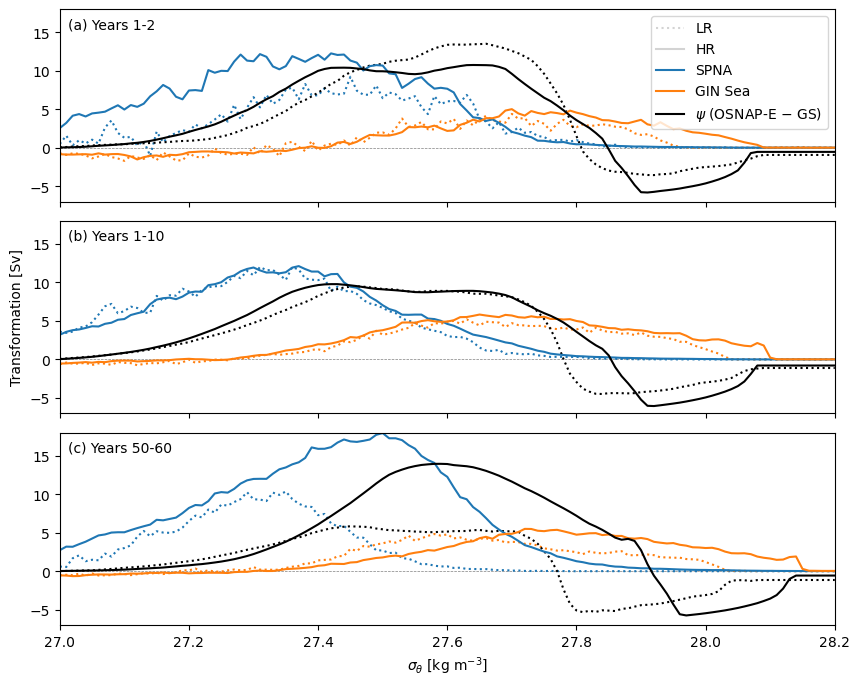

In [41]:
fig, axs = plot_sigma_space()
#fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/sigmaspace.pdf', dpi=200, bbox_inches='tight')